<a href="https://colab.research.google.com/github/peaceemenike/Artificial-Intelligent/blob/main/MLP_Optimizer_Comparison_MNIST/MLP_Optimizer_Comparison_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torch torchvision matplotlib

import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np, matplotlib.pyplot as plt, random, os

# Reproducibility
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

In [ ]:
# transforms: just to tensor
tfm = transforms.ToTensor()

train_full = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
test_ds    = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

USE_SUBSET = True
if USE_SUBSET:
    idx = np.random.RandomState(SEED).choice(len(train_full), size=12000, replace=False)
    train_full = Subset(train_full, idx)

# split into train/val (85/15)
val_size  = int(0.15*len(train_full))
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH = 128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(10200, 1800, 10000)

In [ ]:
# MLP with 2 hidden layers
class MLP(nn.Module):
    def __init__(self, hidden1=256, hidden2=128, p_drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden1), nn.ReLU(),
            nn.Linear(hidden1, hidden2), nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden2, 10)
        )
    def forward(self, x): return self.net(x)


In [ ]:
#Train/eval helpers
def run_epoch(model, loader, criterion, optimizer=None, device=DEVICE):
    if optimizer is None:
        model.eval()
    else:
        model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if optimizer:
            optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        if optimizer:
            loss.backward(); optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum/total, correct/total

def train_model(optimizer_name="sgd", lr=0.1, momentum=0.9, p_drop=0.0, epochs=15):
    torch.manual_seed(SEED)
    model = MLP(p_drop=p_drop).to(DEVICE)
    if optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("optimizer_name must be 'sgd' or 'adam'")
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    for _ in range(epochs):
        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = run_epoch(model, val_loader, criterion, optimizer=None)
        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);  history["val_acc"].append(va_acc)

    test_loss, test_acc = run_epoch(model, test_loader, criterion, optimizer=None)
    return model, history, {"test_loss":test_loss, "test_acc":test_acc}

def plot_history(history, label_prefix):
    # Loss
    plt.figure()
    plt.plot(history["train_loss"], label=f"{label_prefix} Train")
    plt.plot(history["val_loss"],   label=f"{label_prefix} Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Loss: {label_prefix}")
    plt.legend(); plt.grid(True); plt.show()
    # Accuracy
    plt.figure()
    plt.plot(history["train_acc"], label=f"{label_prefix} Train")
    plt.plot(history["val_acc"],   label=f"{label_prefix} Val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"Accuracy: {label_prefix}")
    plt.legend(); plt.grid(True); plt.show()


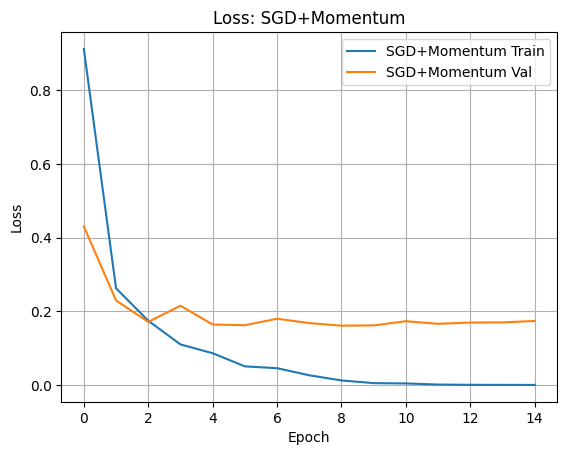

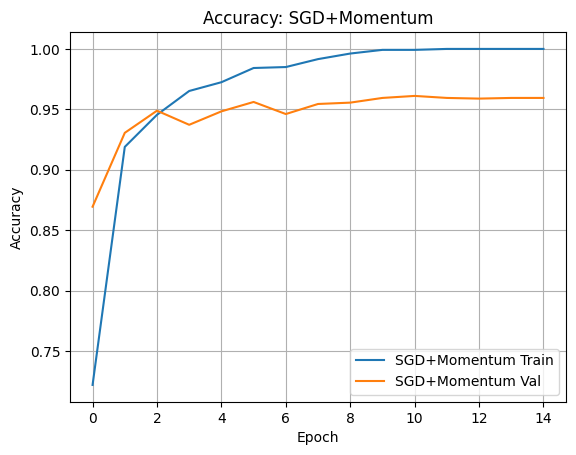

SGD → test_acc:0.965  test_loss:0.1696


In [ ]:
# Case A — SGD with momentum
EPOCHS = 15
model_sgd, hist_sgd, test_sgd = train_model(
    optimizer_name="sgd", lr=0.1, momentum=0.9, p_drop=0.0, epochs=EPOCHS
)
plot_history(hist_sgd, "SGD+Momentum")
print("SGD → test_acc:{:.3f}  test_loss:{:.4f}".format(test_sgd["test_acc"],  test_sgd["test_loss"]))


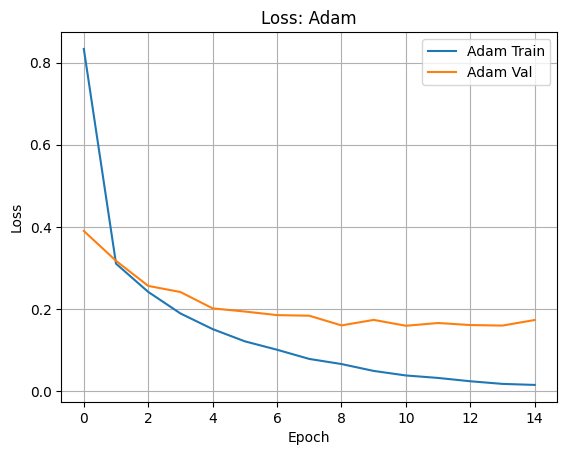

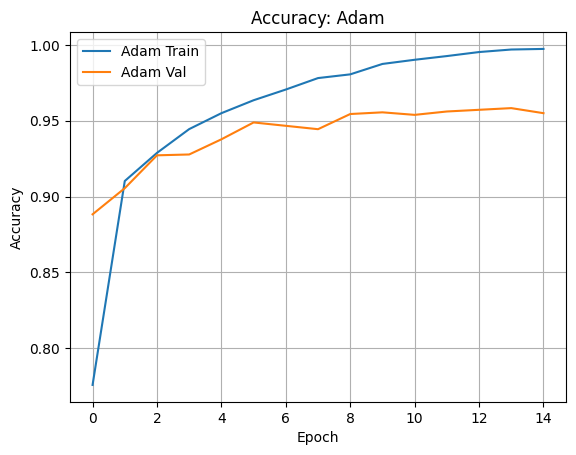

Adam → test_acc:0.951  test_loss:0.1809


In [ ]:
# Case B — Adam
model_adam, hist_adam, test_adam = train_model(
    optimizer_name="adam", lr=1e-3, p_drop=0.0, epochs=EPOCHS
)
plot_history(hist_adam, "Adam")
print("Adam → test_acc:{:.3f}  test_loss:{:.4f}".format(test_adam["test_acc"], test_adam["test_loss"]))


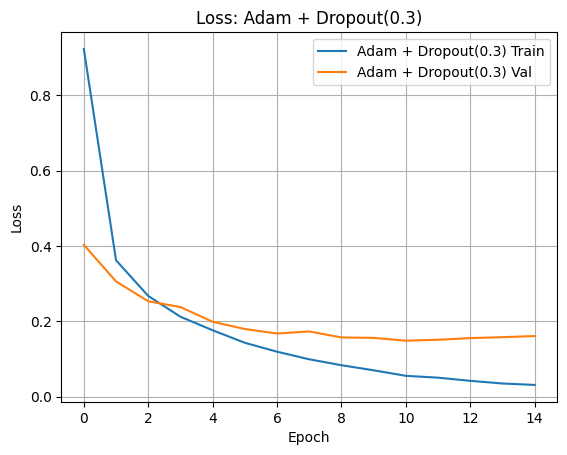

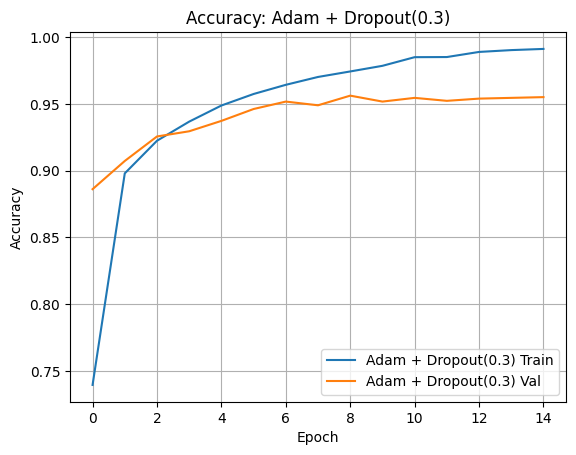

Adam+Dropout → test_acc:0.956  test_loss:0.1641


In [ ]:
# Regularization run — Adam + Dropout
model_do, hist_do, test_do = train_model(
    optimizer_name="adam", lr=1e-3, p_drop=0.3, epochs=EPOCHS
)
plot_history(hist_do, "Adam + Dropout(0.3)")
print("Adam+Dropout → test_acc:{:.3f}  test_loss:{:.4f}".format(test_do["test_acc"], test_do["test_loss"]))


In [ ]:
# Summary cell
import pandas as pd
rows = []
rows.append(["SGD+Momentum", test_sgd["test_acc"], test_sgd["test_loss"]])
rows.append(["Adam",          test_adam["test_acc"], test_adam["test_loss"]])
if 'test_do' in globals():
    rows.append(["Adam + Dropout(0.3)", test_do["test_acc"], test_do["test_loss"]])

pd.DataFrame(rows, columns=["Run","Test Accuracy","Test Loss"])


,Run,Test Accuracy,Test Loss
0,SGD+Momentum,0.9653,0.169605
1,Adam,0.9513,0.180940
2,Adam + Dropout(0.3),0.9562,0.164075
